In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [ ]:
df = pd.read_csv(url)
df.to_csv("course_lead_scoring.csv", index=False)

In [4]:
# read downloaded file
df = pd.read_csv("course_lead_scoring.csv")

In [5]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
target = 'converted'
features = df.columns.tolist()
features.remove(target)

In [7]:
target, features

('converted',
 ['lead_source',
  'industry',
  'number_of_courses_viewed',
  'annual_income',
  'employment_status',
  'location',
  'interaction_count',
  'lead_score'])

In [8]:
# Data preparation

In [ ]:
# * Check if the missing values are presented in the features.
# * If there are missing values:
#     * For caterogiral features, replace them with 'NA'
#     * For numerical features, replace with with 0.0 

for feature in features:
    if df[feature].isnull().sum() > 0:
        print(f"Feature '{feature}' has {df[feature].isnull().sum()} missing values.")
        if df[feature].dtype == 'object':
            df[feature] = df[feature].fillna('NA')
        else:
            df[feature] = df[feature].fillna(0.0)

Feature 'lead_source' has 128 missing values.
Feature 'industry' has 134 missing values.
Feature 'annual_income' has 181 missing values.
Feature 'employment_status' has 100 missing values.
Feature 'location' has 63 missing values.


In [12]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

len(df), len(df_train), len(df_val), len(df_test)

(1462, 876, 293, 293)

In [13]:
# Question 1: ROC AUC feature importance

In [17]:
# ROC AUC could also be used to evaluate feature importance of numerical variables. 

# Let's do that

# * For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
# * Use the training dataset for that


# If your AUC is < 0.5, invert this variable by putting "-" in front

# (e.g. `-df_train['balance']`)

# AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

# Which numerical variable (among the following 4) has the highest AUC?

# - `lead_score`
# - `number_of_courses_viewed`
# - `interaction_count`
# - `annual_income`


numerical_features = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
for feature in numerical_features:
    auc = roc_auc_score(df_train[target], df_train[feature])
    if auc < 0.5:
        auc = roc_auc_score(df_train[target], -df_train[feature])
    print(f"Feature: {feature}, AUC: {auc:.4f}")


Feature: number_of_courses_viewed, AUC: 0.7636
Feature: annual_income, AUC: 0.5520
Feature: interaction_count, AUC: 0.7383
Feature: lead_score, AUC: 0.6145


In [18]:
# Question 2: Training the model

In [ ]:
# Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

# ```python
# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# ```

# What's the AUC of this model on the validation dataset? (round to 3 digits)

In [24]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train[features].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [25]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, df_train[target])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [26]:
val_dicts = df_val[features].to_dict(orient='records')
X_val = dv.transform(val_dicts)
val_preds = model.predict_proba(X_val)[:, 1]

In [31]:
roc_auc = roc_auc_score(df_val[target], val_preds)
round(roc_auc,3)

0.817

In [32]:
# Question 3: Precision and Recall

In [35]:
# Now let's compute precision and recall for our model.

# * Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
# * For each threshold, compute precision and recall
# * Plot them

# At which threshold precision and recall curves intersect?

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
for threshold in thresholds:
    preds = (val_preds >= threshold).astype(int)
    tp = ((df_val[target] == 1) & (preds == 1)).sum()
    fp = ((df_val[target] == 0) & (preds == 1)).sum()
    fn = ((df_val[target] == 1) & (preds == 0)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)

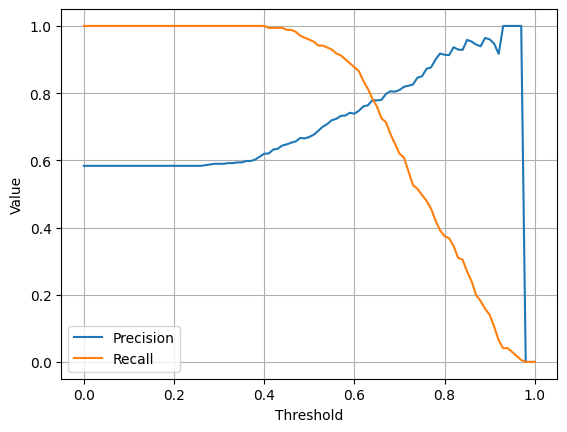

In [39]:
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

In [41]:
# Question 4: F1 score

In [42]:
# Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

# This is the formula for computing F1:

# $$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

# Where $P$ is precision and $R$ is recall.

# Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

# At which threshold F1 is maximal?

In [43]:
f1_scores = []
for precision, recall in zip(precisions, recalls):
    if (precision + recall) == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores.append(f1)

In [44]:
max_f1 = max(f1_scores)

In [45]:
best_threshold = thresholds[f1_scores.index(max_f1)]

In [46]:
best_threshold, max_f1

(np.float64(0.5700000000000001), np.float64(0.8124999999999999))

In [47]:
# Question 5: 5-Fold CV

In [ ]:
# Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

# ```
# KFold(n_splits=5, shuffle=True, random_state=1)
# ```

# * Iterate over different folds of `df_full_train`
# * Split the data into train and validation
# * Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
# * Use AUC to evaluate the model on validation

# How large is standard deviation of the scores across different folds?

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []
for train_index, val_index in kf.split(df_full_train):
    df_train_kf = df_full_train.iloc[train_index]
    df_val_kf = df_full_train.iloc[val_index]
    
    train_dicts_kf = df_train_kf[features].to_dict(orient='records')
    X_train_kf = dv.fit_transform(train_dicts_kf)
    
    model_kf = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_kf.fit(X_train_kf, df_train_kf[target])
    
    val_dicts_kf = df_val_kf[features].to_dict(orient='records')
    X_val_kf = dv.transform(val_dicts_kf)
    val_preds_kf = model_kf.predict_proba(X_val_kf)[:, 1]
    
    auc = roc_auc_score(df_val_kf[target], val_preds_kf)
    auc_scores.append(auc)

In [50]:
np.std(auc_scores)
round(np.std(auc_scores), 3)

np.float64(0.036)

In [51]:
# Question 6: Hyperparameter Tuning

In [52]:
# Now let's use 5-Fold cross-validation to find the best parameter `C`

# * Iterate over the following `C` values: `[0.000001, 0.001, 1]`
# * Initialize `KFold` with the same parameters as previously
# * Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
# * Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

# Which `C` leads to the best mean score?

In [53]:
C_values = [0.000001, 0.001, 1]
best_mean_auc = 0
best_C = None

for C in C_values:
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    auc_scores = []
    for train_index, val_index in kf.split(df_full_train):
        df_train_kf = df_full_train.iloc[train_index]
        df_val_kf = df_full_train.iloc[val_index]
        
        train_dicts_kf = df_train_kf[features].to_dict(orient='records')
        X_train_kf = dv.fit_transform(train_dicts_kf)
        
        model_kf = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_kf.fit(X_train_kf, df_train_kf[target])
        
        val_dicts_kf = df_val_kf[features].to_dict(orient='records')
        X_val_kf = dv.transform(val_dicts_kf)
        val_preds_kf = model_kf.predict_proba(X_val_kf)[:, 1]
        
        auc = roc_auc_score(df_val_kf[target], val_preds_kf)
        auc_scores.append(auc)
    
    mean_auc = round(np.mean(auc_scores), 3)
    std_auc = round(np.std(auc_scores), 3)
    print(f"C: {C}, Mean AUC: {mean_auc}, Std AUC: {std_auc}")
    
    if mean_auc > best_mean_auc:
        best_mean_auc = mean_auc
        best_C = C

print(f"Best C: {best_C} with Mean AUC: {best_mean_auc}")

C: 1e-06, Mean AUC: 0.56, Std AUC: 0.024
C: 0.001, Mean AUC: 0.867, Std AUC: 0.029
C: 1, Mean AUC: 0.822, Std AUC: 0.036
Best C: 0.001 with Mean AUC: 0.867
